# Wildberry data : A prediction challenge

In this data set, given training data, we will try to fit an OLS model and a KDE model to it. With the model, we shall try to predict test values and check their accuracy by using the metric as Mean Absolute Error.

# Table of Contents
1. [Importing necessary libraries](#Importing)
2. [Loading train and test data](#Loading)
3. [Analysing the data](#analyse)
4. [Feature reduction](#reduction)
5. [Incorporating changes](#changes)
6. [Normalising the data](#normal)
7. [MAE function](#MAE)
8. [OLS](#OLS)
9. [Kernel Regression](#KDE)
10. [Writing the prediction](#write)


## Importing necessary libraries
<a id="Importing"></a>


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import seaborn as sns
from scipy import stats

## Loading train and test data
<a id="Loading"></a>

In [2]:
# Loading the train and test data

df = pd.read_csv("train.csv")

about_target = {}

about_target["max"] = df["yield"].max()
about_target["min"] = df["yield"].min()
about_target["avg"] = df["yield"].mean()
about_target["std_dev"] = df["yield"].std()

features = (list(df.columns[:-1]))
target = df.columns[-1]

    
df_test = pd.read_csv("test.csv")
about_target

{'max': 8969.40184,
 'min': 1637.70402,
 'avg': 6033.586197244667,
 'std_dev': 1349.8013336229396}

## Analysing the data
<a id="analyse"></a>

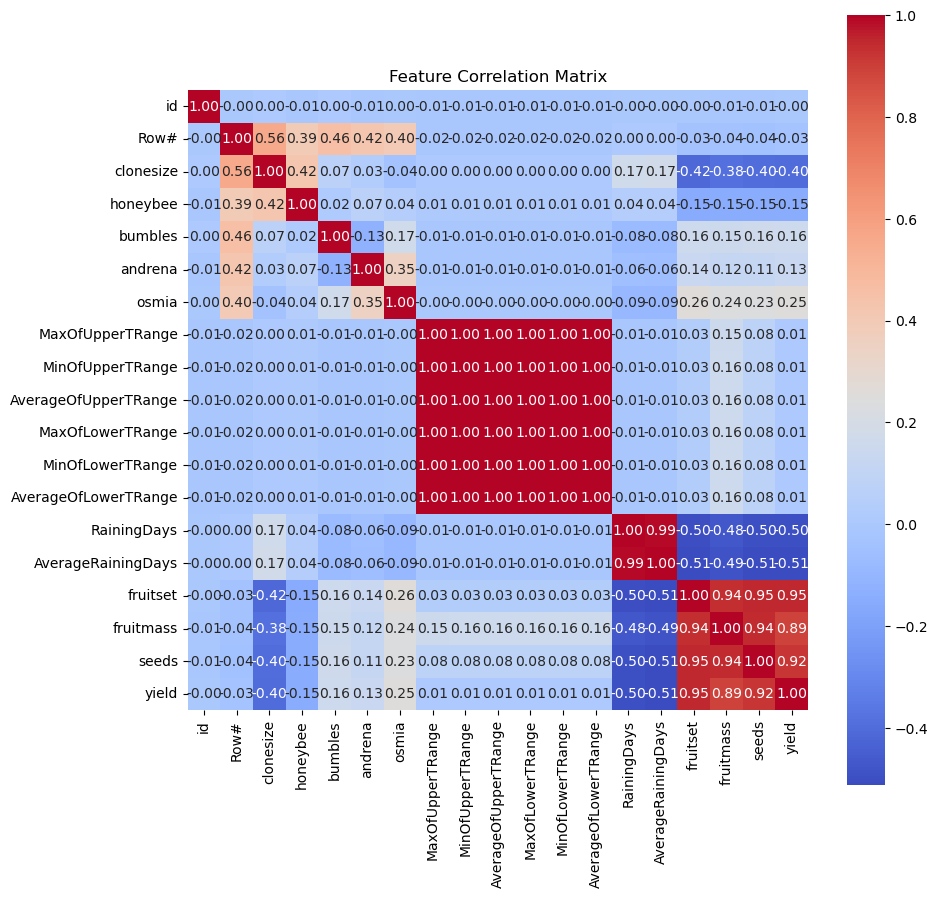

In [3]:

# Check correlation matrix between features and target
correlation_matrix = df.corr()

# Display the full correlation matrix


plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Feature Correlation Matrix")
plt.show()


In [4]:
# Checking for multicollinearity

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

# Function to calculate VIF
def calculate_vif(data):
    # Standardize the data for better interpretability
    features = data.drop(columns=[target])
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    vif_data = pd.DataFrame()
    vif_data["feature"] = features.columns
    vif_data["VIF"] = [variance_inflation_factor(data_scaled, i) for i in range(features.shape[1])]

    return vif_data

# Example usage
# Assuming 'df' is your DataFrame containing the predictor variables (features)
# df = pd.read_csv("your_dataset.csv")
vif_df = calculate_vif(df)

print(vif_df)

                 feature           VIF
0                     id  1.000976e+00
1                   Row#  4.208089e+00
2              clonesize  2.402735e+00
3               honeybee  1.331498e+00
4                bumbles  1.932669e+00
5                andrena  1.820092e+00
6                  osmia  1.431489e+00
7       MaxOfUpperTRange  3.373645e+06
8       MinOfUpperTRange  9.973185e+05
9   AverageOfUpperTRange  1.025934e+05
10      MaxOfLowerTRange  5.357633e+03
11      MinOfLowerTRange  9.263712e+06
12  AverageOfLowerTRange  1.521571e+03
13           RainingDays  6.139443e+01
14    AverageRainingDays  6.240291e+01
15              fruitset  1.958775e+01
16             fruitmass  1.351205e+01
17                 seeds  1.365410e+01


In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Assuming df is your original DataFrame and 'yield' is your target variable
X = df.drop('yield', axis=1)  # Features
y = df['yield']                # Target variable

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Create DataFrames for training and testing
train_df = pd.concat([X_train, Y_train], axis=1)
test_df = pd.concat([X_test, Y_test], axis=1)

# Output the shapes of the resulting DataFrames
print("Training DataFrame Shape:", train_df.shape)
print("Testing DataFrame Shape:", test_df.shape)

# Display the first few rows of each DataFrame


null_counts = df.isnull().sum()
null_counts


Training DataFrame Shape: (12000, 19)
Testing DataFrame Shape: (3000, 19)


id                      0
Row#                    0
clonesize               0
honeybee                0
bumbles                 0
andrena                 0
osmia                   0
MaxOfUpperTRange        0
MinOfUpperTRange        0
AverageOfUpperTRange    0
MaxOfLowerTRange        0
MinOfLowerTRange        0
AverageOfLowerTRange    0
RainingDays             0
AverageRainingDays      0
fruitset                0
fruitmass               0
seeds                   0
yield                   0
dtype: int64

## Feature reduction
<a id="reduction"></a>

This confirms our hypothesis that Temperature features are highly correlated. So, we'll keep one of them, and check for VIF. Similarly, fruitset, fruitmass and seeds are highly correlated, so we'll go with the feature which has a higher correlation with the target and drop the remaining. And, AvgRainingDays and RainingDays have a linear relationship. Since Avg has a higher magnitude of correlation, we'll keep it. This feature reduction is reflected on top as well, although changes here have been done to a copy of the data frame.


In [6]:
columns_to_drop = ['Row#','MaxOfUpperTRange','MinOfUpperTRange','MaxOfLowerTRange', 'MinOfLowerTRange', "AverageOfUpperTRange"]

# Only drop columns that are present in the DataFrame

train_df.drop([col for col in columns_to_drop if col in train_df.columns], axis='columns', inplace=True)
test_df.drop([col for col in columns_to_drop if col in test_df.columns], axis='columns', inplace=True)
df_test.drop([col for col in columns_to_drop if col in df_test.columns], axis='columns', inplace=True)

vif_df = calculate_vif(train_df)
vif_df

,feature,VIF
0,id,1.000671
1,clonesize,1.593551
2,honeybee,1.332760
3,bumbles,1.128666
4,andrena,1.219509
5,osmia,1.264774
6,AverageOfLowerTRange,1.159842
7,RainingDays,60.772954
8,AverageRainingDays,61.702824
9,fruitset,19.653985


In [7]:
# Checking for outliers

z_scores = np.abs(stats.zscore(train_df))

threshold = 2.5

df_no_outliers = train_df[(z_scores < threshold).all(axis=1)]

# Print the number of rows before and after removing outliers

print(f"Original dataset shape: {train_df.shape}")
print(f"Dataset shape after removing outliers: {df_no_outliers.shape}")

print(type(df_no_outliers))

Original dataset shape: (12000, 13)
Dataset shape after removing outliers: (11589, 13)
<class 'pandas.core.frame.DataFrame'>


In [8]:
# Checking if Z-scores removed the outliers present earlier

unique_values = train_df['honeybee'].unique()
print(unique_values)

outliers = [18.43, 6.64]

train_df = train_df[~train_df['honeybee'].isin(outliers)]


[ 0.25   0.5    0.75   0.537  0.    18.43   6.64 ]


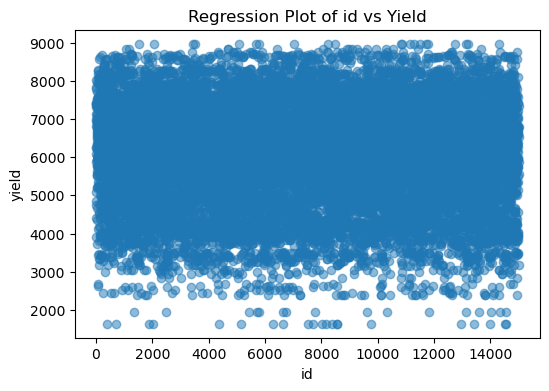

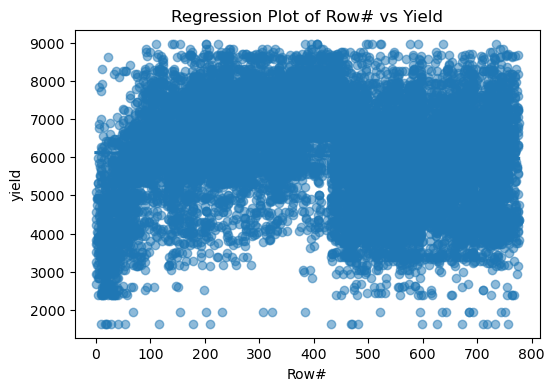

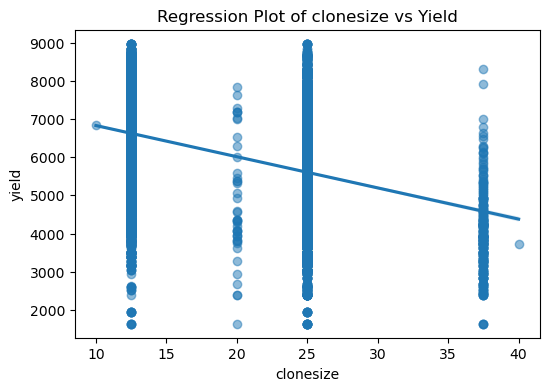

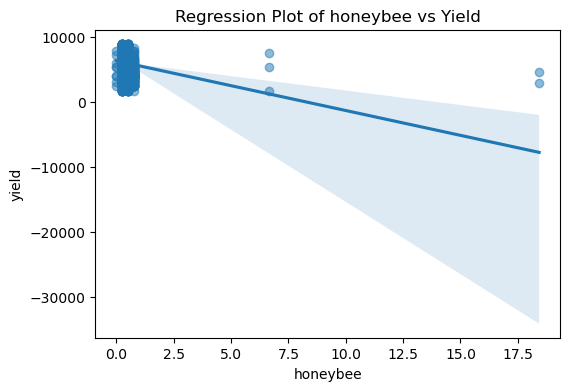

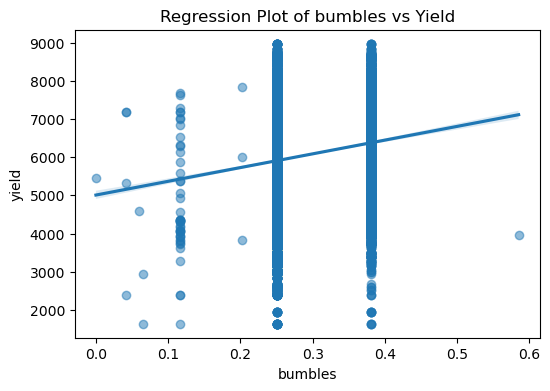

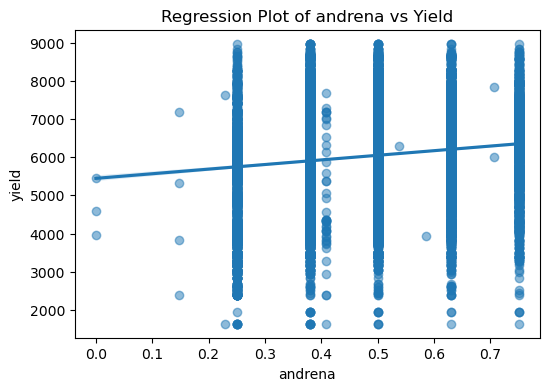

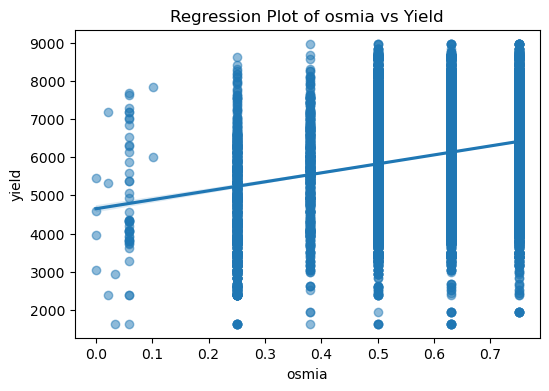

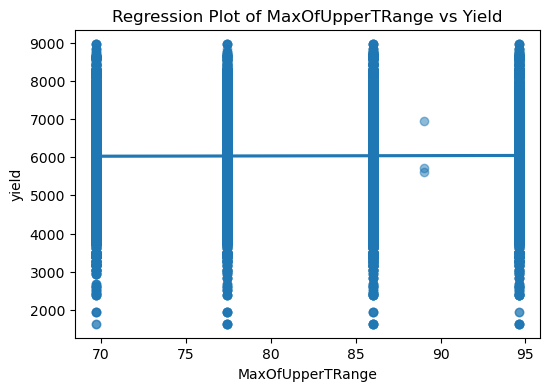

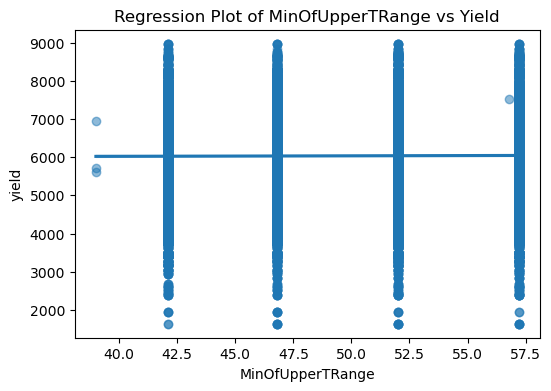

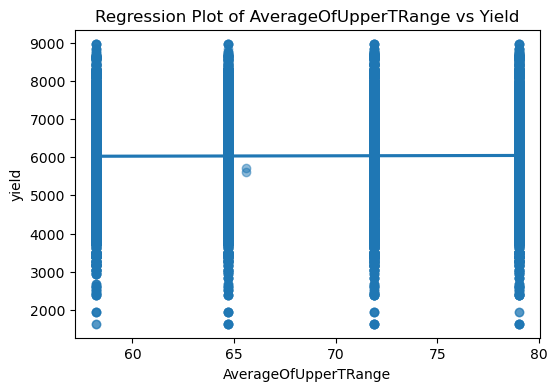

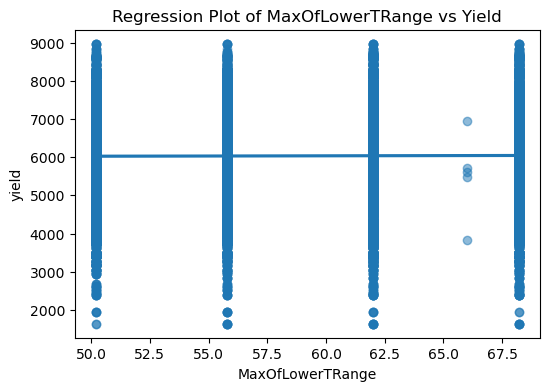

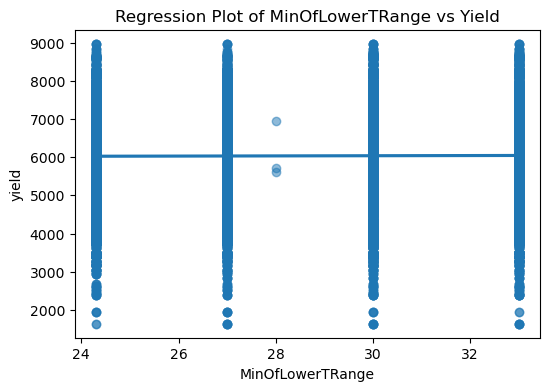

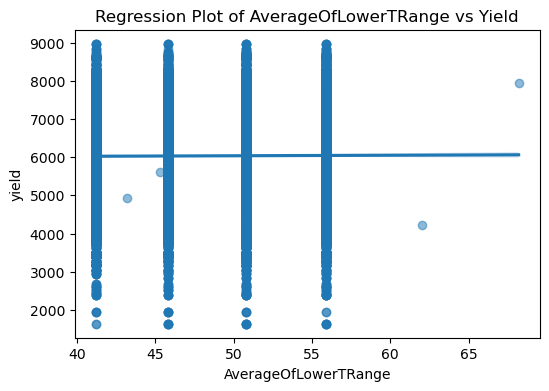

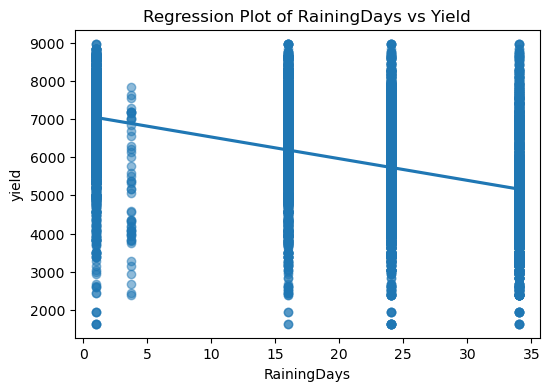

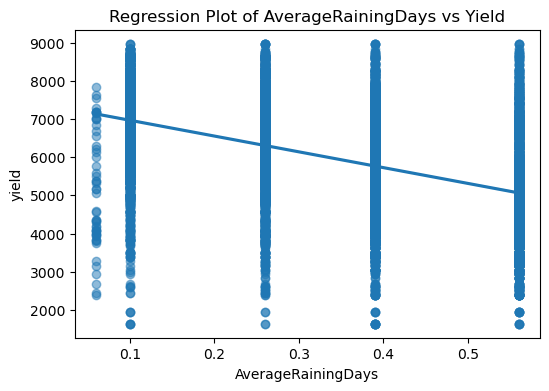

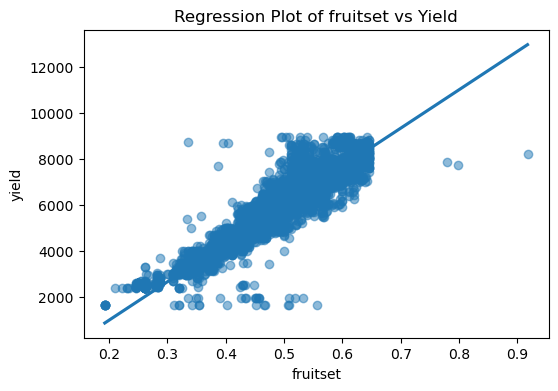

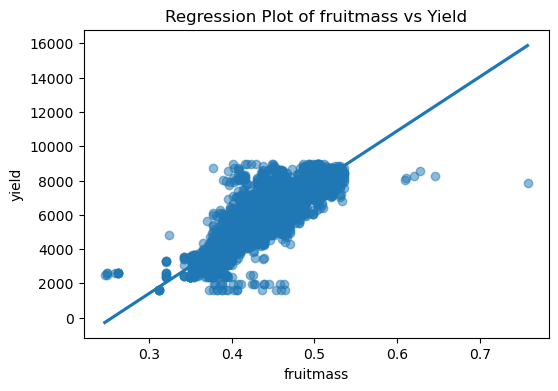

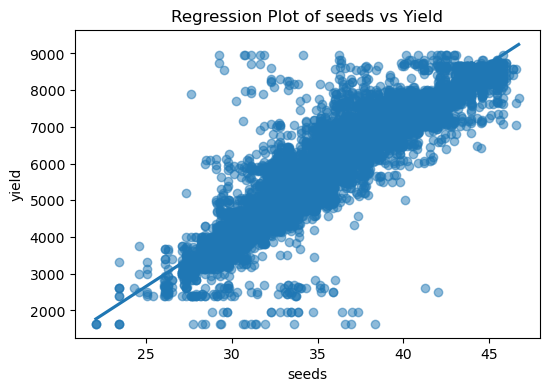

In [9]:

# Creating regression plots with all the features
for feature in features:
    plt.figure(figsize=(6, 4))
    sns.regplot(x=feature, y='yield', data=df, scatter_kws={'alpha':0.5})
    plt.title(f'Regression Plot of {feature} vs Yield')
    plt.show()


Feature importances: [1.23414385e-02 1.06725849e-02 7.56959718e-04 5.63400384e-04
 9.68854739e-04 2.73672830e-03 2.94625724e-03 1.05135717e-03
 1.33278838e-03 1.07615333e-03 1.14641170e-03 1.13709508e-03
 1.24578869e-03 1.78630199e-03 1.80465152e-03 8.43062751e-01
 1.35619812e-02 1.01808496e-01]


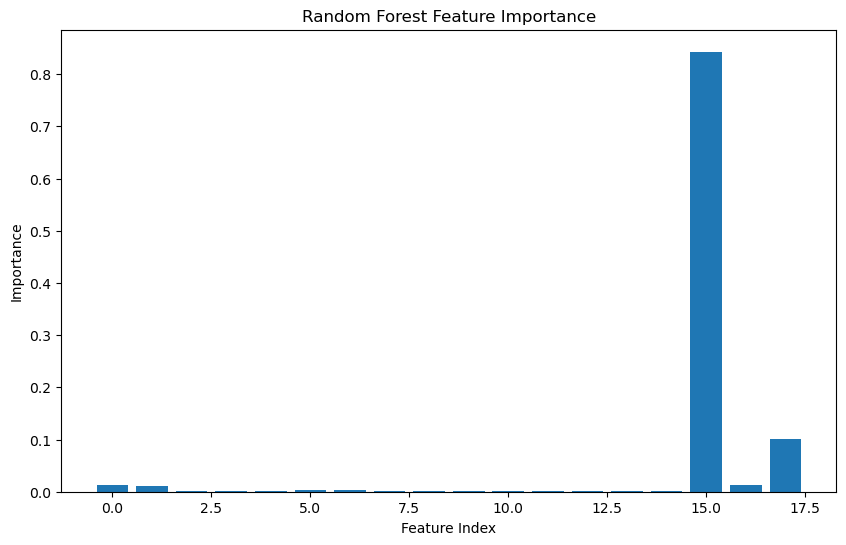

['id', 'Row#', 'clonesize', 'honeybee', 'bumbles', 'andrena', 'osmia', 'MaxOfUpperTRange', 'MinOfUpperTRange', 'AverageOfUpperTRange', 'MaxOfLowerTRange', 'MinOfLowerTRange', 'AverageOfLowerTRange', 'RainingDays', 'AverageRainingDays', 'fruitset', 'fruitmass', 'seeds']


In [10]:
from sklearn.ensemble import RandomForestRegressor


# Normalize your dataset
def normalize(X):
    return (X - np.mean(X, axis=0)) / np.std(X, axis=0)

# Your existing data (assuming X_train, Y_train, X_test, and Y_test are already defined)
# Normalize the features
X_train_norm = normalize(X_train)
X_test_norm = normalize(X_test)

# Train Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_norm, Y_train)

# Feature Importance
feature_importances = rf.feature_importances_

# Print feature importances
print("Feature importances:", feature_importances)

# Plotting feature importance for visualization
plt.figure(figsize=(10, 6))
plt.bar(range(X_train_norm.shape[1]), feature_importances)
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.title('Random Forest Feature Importance')
plt.show()
print(features)

fruitset                1.659584
seeds                   1.313670
fruitmass               1.149700
AverageRainingDays      0.203547
RainingDays             0.199892
Row#                    0.170394
clonesize               0.104431
osmia                   0.054749
honeybee                0.052547
andrena                 0.028523
bumbles                 0.015813
MaxOfLowerTRange        0.011833
AverageOfUpperTRange    0.011178
MinOfUpperTRange        0.008671
MinOfLowerTRange        0.008096
id                      0.006571
MaxOfUpperTRange        0.006285
AverageOfLowerTRange    0.005698
dtype: float64


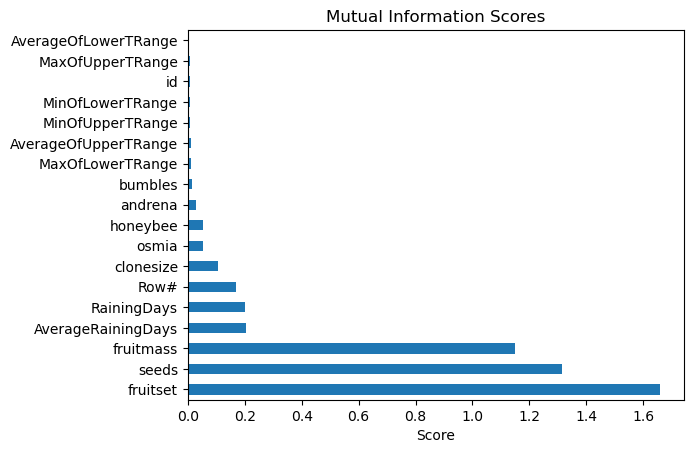

In [11]:
import pandas as pd
from sklearn.feature_selection import mutual_info_regression

# Example DataFrame
# df = pd.read_csv('your_data.csv')

# One-hot encoding for categorical features
df_encoded = pd.get_dummies(df, drop_first=True)

# Define features and target variable
X = df_encoded.drop(columns=['yield'])  # Features
y = df_encoded['yield']  # Target variable

# Calculate mutual information scores
mi_scores = 0

for i in range(1):
    mi_scores += mutual_info_regression(X, y)
mi_scores = mi_scores / 1

# Create a DataFrame for better visualization
mi_scores_df = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

# Print mutual information scores
print(mi_scores_df)

# Plot mutual information scores
import matplotlib.pyplot as plt

mi_scores_df.plot(kind='barh', title='Mutual Information Scores')
plt.xlabel('Score')
plt.show()


## Incorporating changes
<a id="changes"></a>

In [12]:
# Shuffling the data

df = df.sample(frac=1, random_state=42).reset_index(drop=True)


# Dropping the columns which have little correlation or are irrelavant

columns_to_drop = ['Row#','MaxOfUpperTRange','MinOfUpperTRange','MaxOfLowerTRange', 'MinOfLowerTRange', "AverageOfUpperTRange"]


df.drop([col for col in columns_to_drop if col in df.columns], axis='columns', inplace=True)

# print(df)
about_target = {}

about_target["max"] = df["yield"].max()
about_target["min"] = df["yield"].min()
about_target["avg"] = df["yield"].mean()
about_target["std_dev"] = df["yield"].std()

features = (list(df.columns[:-1]))

target = df.columns[-1]

print(len(features))
    
    
df_test.drop([col for col in columns_to_drop if col in df.columns], axis='columns', inplace=True)

12


In [13]:
# Since fruitsets and seeds are highly correlated, we'll create a feature for them

df['fruits_seeds'] = df['fruitset'] * df['seeds']

df.insert(0, 'fruits_seeds', df.pop('fruits_seeds'))

df.set_index("id", inplace = True)


# doing the same for test

df_test['fruits_seeds'] = df_test['fruitset'] * df_test['seeds']


df_test.insert(0, 'fruits_seeds', df_test.pop('fruits_seeds'))


print(df_test.head())


   fruits_seeds     id  clonesize  honeybee  bumbles  andrena  osmia  \
0     13.352189  15000       25.0      0.50     0.25     0.38   0.63   
1     21.220210  15001       12.5      0.25     0.25     0.63   0.63   
2     18.148523  15002       25.0      0.25     0.25     0.25   0.25   
3     19.634533  15003       25.0      0.50     0.38     0.38   0.63   
4     16.858929  15004       12.5      0.25     0.25     0.38   0.25   

   AverageOfLowerTRange  RainingDays  AverageRainingDays  fruitset  fruitmass  \
0                  45.8         24.0                0.39  0.424574   0.417909   
1                  41.2         16.0                0.26  0.552359   0.476308   
2                  41.2         24.0                0.39  0.511413   0.445494   
3                  50.8         24.0                0.39  0.520637   0.460795   
4                  55.9         16.0                0.26  0.470593   0.438026   

       seeds  
0  31.448420  
1  38.417394  
2  35.487008  
3  37.712513  
4  35

In [14]:
# Doing the train test split

features = (list(df.columns[:-1]))

target = df.columns[-1]

print(len(features))
X = np.array(df[features])
Y = df[target]

print(X.shape)
print(Y.shape)

split = 12000

X_train = X[0:split]
X_test = X[split:]

Y_train = Y[0:split]
Y_test = Y[split:]
if (split == 15000):
    X_test = X_train
    Y_test = Y_train
X_predict = np.array(df_test[features])

df_test.head()

12
(15000, 12)
(15000,)


,fruits_seeds,id,clonesize,honeybee,bumbles,andrena,osmia,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds
0,13.352189,15000,25.0,0.50,0.25,0.38,0.63,45.8,24.0,0.39,0.424574,0.417909,31.448420
1,21.220210,15001,12.5,0.25,0.25,0.63,0.63,41.2,16.0,0.26,0.552359,0.476308,38.417394
2,18.148523,15002,25.0,0.25,0.25,0.25,0.25,41.2,24.0,0.39,0.511413,0.445494,35.487008
3,19.634533,15003,25.0,0.50,0.38,0.38,0.63,50.8,24.0,0.39,0.520637,0.460795,37.712513
4,16.858929,15004,12.5,0.25,0.25,0.38,0.25,55.9,16.0,0.26,0.470593,0.438026,35.824852


## Normalising the data
<a id="normal"></a>

In [15]:
# function for normalising the data

def normalise(data):
    return (data - np.mean(data, axis = 0))/(np.std(data, axis = 0))

## MAE function
<a id="MAE"></a>

In [16]:
# MAE 

def MAE(prediction, target):
    return np.mean(np.abs(prediction - target))

## OLS
<a id="OLS"></a>
Considering a OLS for upto a given degree for each parameter

$\beta = (X^T X)^{-1}X^Ty$

In [17]:
## Redundant implementation

def OLS(df, power):
    features = list(df.columns[:-1])
    target = df.columns[-1]
    X_1 = np.array(df[features])
    X_1s = np.ones(X_1.shape[0]).reshape(-1, 1)
    X = np.append(X_1s, X_1, axis = 1)
    exp = 2
    while(exp <= power):
        X_n = np.power(X_1, exp)
        X = np.append(X, X_n, axis = 1)
        exp = exp + 1
    Y = df[target] 
    
    return np.matmul(np.matmul(np.linalg.pinv(np.array(np.matmul(X.T, X))), X.T), Y), X

def fitLevel(df, power):
    beta, X = OLS(df, power)
    Y = df[target]
    
    predict_train = np.matmul(X, beta)
    return np.mean(np.abs(predict_train - Y))

def write_predictionOLS(df_test, param, power):
    _, X_test = OLS(df_test, power)
    prediction = np.matmul(X_test, param)
    row_num = np.array(df_test["id"])
    
    with open("predictionOLS.csv", mode="w", newline="\n") as fout:
        wcsv = csv.writer(fout)
        for index in range(len(row_num)):
            wcsv.writerow([row_num[index], prediction[index]])
    
# fitLevel(df, 1)
# beta, _ = OLS(df, 1)

# write_predictionOLS(df_test, beta, 1)

### Problem with using raw data
Here, as we increase the degree of the polynomial, the Mean Absolute Error diverges. This is because of the huge values which we get when we raise the values we have to some exponent. To overcome this, we shall normalise our data. This is done by subtracting the mean and dividing by the standard deviation, after we expand the data.

In [18]:
# To expand the feature matrix according to the given power

def expand(X, power):
    X_1 = (X)
    X_const = np.ones(X_1.shape[0]).reshape(-1, 1)
    X_f = np.append(X_const, normalise(X_1), axis = 1)
    exp = 2
    while(exp <= power):
        X_n = np.power(X_1, exp)
        X_f = np.append(X_f, normalise(X_n), axis = 1)
        exp = exp + 1
    return X_f

# OLS with normalised data

def OLS_norm(X, Y, power):
    
    X_train = expand(X, power)
    
    return np.matmul(np.matmul(np.linalg.pinv(np.array(np.matmul(X_train.T, X_train))), X_train.T), Y), X_train

# finding the optimal degree

def find_opt(X_train, Y_train, X_test, Y_test, degree):
    
    param, X_train_poly = OLS_norm(X_train, Y_train, 1)

    power = 1
    
    X_test_poly = expand(X_test, 1)
    
    predict = np.matmul(X_test_poly, param)
    
    mae = MAE(predict, Y_test)
    
    for exp in range(2, degree + 1):
        
        beta, X_test_poly = OLS_norm(X_train, Y_train, exp)
        predict = np.matmul(expand(X_test, exp), beta)
        
        if (MAE(predict, Y_test) < mae):
            mae = MAE(predict, Y_test) 
            param = beta
            power = exp
    return param, power

# For checking the level of fit

def fitLevel(param, X, Y):
    
    predict_train = np.matmul(X, param)
    return np.mean(np.abs(predict_train - Y))   


# finding the optimum degree

opt_param, opt_degree = find_opt(X_train, Y_train, X_test, Y_test, 20)

# param, X_train_poly = OLS(X_train, Y_train, 3)

# # print(expand(X_test, 4).shape)
print(fitLevel(opt_param, expand(X_test, opt_degree), Y_test))



# Getting the parameters with respect to the entire dataset
opt_param, _ = OLS_norm(X, Y, opt_degree)

print(opt_degree, opt_param)

253.13055678826555
3 [ 6.03358620e+03  1.03021083e+04  1.47129214e+02  2.97570468e+01
 -9.84494685e+00 -2.58330049e+02  5.79922687e+01 -9.67367395e+03
  7.75957266e+01 -2.15085381e+01 -5.45029061e+03  8.03145352e+01
  8.67045668e+02 -1.04569007e+04 -3.10525356e+02 -1.50305306e+02
  7.35007083e+01  5.83585970e+02 -5.87160578e+01  1.81081569e+04
 -1.22187841e+02 -1.01196753e+02  6.84982207e+03 -2.15229745e+02
 -9.22167261e+03  2.31669717e+03  1.49761023e+02  1.23752216e+02
 -6.02929358e+01 -3.30467463e+02  1.56202529e+01 -8.49286010e+03
  4.97522151e+01  1.05556189e+02 -1.84015359e+03  1.49670312e+02
  7.83931385e+03]


In [19]:
# Ridge Regularization 

# Here we penalise large coefficients, to make sure that overfitting doens't happen

def ridge_regression(X, Y, power, alpha=1.0):
    X_train = expand(X, power)
    
    reg_matrix = alpha * np.eye(X_train.shape[1])
    reg_matrix[0, 0] = 0 
    
    beta = np.matmul(np.linalg.pinv(np.matmul(X_train.T, X_train) + reg_matrix), np.matmul(X_train.T, Y))
    
    return beta, X_train


def find_opt_with_regularization(X_train, Y_train, X_test, Y_test, degree, alpha=1.0):
    param, X_train_poly = None, None
    mae = float('inf')
    power = 1
    
    for exp in range(1, degree + 1):
        beta, X_train_poly = ridge_regression(X_train, Y_train, exp, alpha)

        
        X_test_poly = expand(X_test, exp)
        predict = np.matmul(X_test_poly, beta)
        current_mae = MAE(predict, Y_test)
        
        if current_mae < mae:
            mae = current_mae
            param = beta
            power = exp
    
    return param, power


alpha = 0.015  # Regularization strength
param_ridge, opt_degree_ridge = find_opt_with_regularization(X_train, Y_train, X_test, Y_test, degree=10, alpha=alpha)
print(f"Optimal degree (Ridge): {opt_degree_ridge}")
print(f"Ridge Regression MAE: {fitLevel(param_ridge, expand(X_test, opt_degree_ridge), Y_test)}")


Optimal degree (Ridge): 6
Ridge Regression MAE: 252.31979799851626


In [20]:

# Instead of raising everything to the same power, we raise features to a particular power based on their degree

def correlation_to_degree(correlation, max_degree=4):
    abs_corr = abs(correlation)
    if abs_corr > 0.75:
        return max_degree
    elif abs_corr > 0.5:
        return 3
    elif abs_corr > 0.25:
        return 2
    else:
        return 1

def expand_with_corr(df):
    df_features = df.drop(columns='yield') 
    df_target = df['yield'].values.reshape(-1, 1)
    
    correlations = df_features.corrwith(df['yield'])
    
    degrees = {col: correlation_to_degree(correlations[col]) for col in df_features.columns}
    
    poly_X = np.ones((df_features.shape[0], 1))
    
    for col in df_features.columns:
        degree = degrees[col]
        for d in range(1, degree + 1):
            poly_X = np.hstack((poly_X, normalise((df_features[col].values ** d).reshape(-1, 1))))
    return poly_X, df_target

def OLS_normm(df):
    
    X_train, Y = expand_with_corr(df)
    
    return np.matmul(np.matmul(np.linalg.pinv(np.array(np.matmul(X_train.T, X_train))), X_train.T), Y), X_train
# expand_with_corr(df)


In [21]:
poly_X, y = expand_with_corr(df)

beta = np.linalg.pinv(poly_X.T @ poly_X) @ (poly_X.T @ y)

# Predict the target values on the training data
y_pred = poly_X @ beta

# Optionally, print the coefficients (beta values)
print(f"Coefficients (beta): {beta.flatten()}")


Coefficients (beta): [ 6.03358620e+03  3.46202344e+04 -3.46795270e+04  6.12105308e+03
  3.18940279e+03 -5.20995001e+00 -8.59981609e+00 -2.67280814e-01
  5.00951671e+00  1.91553309e+00  5.04728184e+01 -3.40456545e+01
 -2.93421688e+01  1.11189953e+01 -2.45685231e+02  1.48104465e+02
 -1.44986156e+02  2.16120524e+02 -1.10224176e+04 -8.54693745e+03
  2.87208698e+04 -1.38404662e+04  5.36730743e+03 -1.51991036e+04
  1.35793772e+04 -3.81372633e+03  9.88282902e+04 -3.35902458e+05
  3.56420635e+05 -1.22757568e+05]


## Kernel Regression
<a id="KDE"></a>

In [22]:
def gaussian_kernel(values):
    return (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * (values ** 2))


def epanechikov_kernel(values):
    # create a mask for valid values
    valid_mask = np.abs(values) <= 1
    # create an array of zeros with the same size as the input values
    kernel_values = np.zeros(values.size)
    # set the valid values to the kernel values
    kernel_values[valid_mask] = 0.75 * (1 - values[valid_mask] ** 2)
    return kernel_values


def naradaya_watson(Y, X, center, h, kernel='gaussian'):

    kernel_weights = []
    if kernel == 'gaussian':
        kernel_weights = gaussian_kernel(np.linalg.norm(center - X, axis = 1) / h)
    elif kernel == 'epanechikov':
        kernel_weights = epanechikov_kernel(np.linalg.norm(center - X, axis = 1) / h)

    # if the sum of the kernel weights, to avoid division by zero
    if (np.sum(kernel_weights) == 0):
        return 0

    return np.sum(Y * kernel_weights) / np.sum(kernel_weights)


def cross_validation(X, Y, h, kernel='gaussian'):
    abs_errors = []
    print(h)

    for row_i in range(len(X)):
        if row_i % 1000 == 0: print(row_i)
        # set to be trained on
        X_train = np.delete(X, row_i, axis = 0)
        Y_train = np.delete(Y, row_i, axis = 0)

        # set to be tested on
        X_test = X[row_i]
        Y_test = Y[row_i]

        # predict Y value and calculate squared error
        

        Y_pred = naradaya_watson(Y_train, X_train, X_test, h, kernel)
        abs_errors.append(np.abs(Y_pred - Y_test))

    return np.mean(abs_errors)


def NW_multivariate(Y_train, X_train, bandwidth):
    squared_errors = []
#     print(X_train.size)
    for index in range(len(X_train)):
        
        Y_pred = naradaya_watson(Y_train[index], X_train, X_train[index], 0.1)
        squared_errors.append(abs(Y_pred - Y_train))
        
    return np.mean(squared_errors)

def find_optimal_h(X, Y, kernel='gaussian'):
    # h values to be tested
    
    h_values = np.linspace(1, 2, 5)
    # array to store squared errors
    abs_errors = [cross_validation(X, Y, h, kernel) for h in h_values]
    # optimized h is the one that minimizes the squared errors
    return h_values[np.argmin(abs_errors)], abs_errors


# opt_h_gaussian, abs_errors_g = find_optimal_h(X_train, Y_train)
# # cross_validation(X_train, Y_train, 2)

## Writing the prediction
<a id="write"></a>

In [23]:
# After we have figured out the optimum degree, we train on the entire data set and use it to predict

def write_prediction(df_test, X_test, param):

    prediction = np.matmul(X_test, param)
    row_num = np.array(df_test["id"])
    
    with open("submission.csv", mode="w", newline="\n") as fout:
        wcsv = csv.writer(fout)
        wcsv.writerow(["id", "yield"])
        for index in range(len(row_num)):
            wcsv.writerow([row_num[index], prediction[index]])

print(X_predict.shape)
write_prediction(df_test, expand(X_predict, opt_degree), opt_param)


(10000, 12)
